In [241]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from turtle import speed

In [242]:
class SimulationObject():

    def __init__(self, acc=(0,0,0), vel=(0,0,0), loc=(0,0,0), bounce_cor=1) -> None:
        self.acc = np.array(acc)
        self.vel = np.array(vel)
        self.loc = np.array(loc)
        self.bounce_cor = bounce_cor
        self.collision_counter = 0

    def update_vel(self, dt):
        self.vel =  self.acc * dt + self.vel
        return self.vel


    def update_loc(self, dt):
        self.loc = 0.5 * self.acc * np.power(dt,2) + self.vel * dt + self.loc
        return self.loc

    def update_without_collision(self, dt):
        self.update_vel(dt)
        self.update_loc(dt)
        return self

    def update(self, dt, obstacle):
        prev_vel = self.vel
        prev_loc = self.loc
        self.update_vel(dt)
        self.update_loc(dt)

        intersection = self.solve_intersection(obstacle.point_0, obstacle.point_1, prev_loc, self.loc)

        if self.is_collision(intersection[1], intersection[2]):
            dt_collision = intersection[2] * dt
            self.vel = prev_vel # reset
            self.loc = prev_loc # reset
            self.update_vel(dt_collision)
            self.loc = intersection[0]
            
            if len(self.vel) == 2: # 2D
                help_z = np.array([0, 0, 1])
                obstacle_orthogonal = np.cross(obstacle.point_1 - obstacle.point_0, help_z)
                obstacle_orthogonal = np.array([obstacle_orthogonal[0], obstacle_orthogonal[1]]) # drop z
            else: # 3D
                print("implement plane here") # TODO


            self.vel = self.vel - 2 * (np.dot(self.vel, obstacle_orthogonal))/(np.dot(obstacle_orthogonal, obstacle_orthogonal)) * obstacle_orthogonal # bounce reflect velocity
            self.vel = self.vel * self.bounce_cor # bounce losses
            self.update_vel(dt-dt_collision)
            self.update_loc(dt-dt_collision)

            """
            if self.vel < 0: # ball has not enough energy cross border
                self.vel = 0
                self.loc = obstacle.z
            """

            self.collision_counter = self.collision_counter + 1

            return self
            
        else:
            return self

    def solve_intersection(self, a, b, c, d):
        # https://www.youtube.com/watch?v=5FkOO1Wwb8w&ab_channel=EngineerNick
        # https://replit.com/@thehappycheese/linetools#LineTools/line_tools.py
        # computes the intersection between two line segments; a to b, and c to d

        ab = b - a
        cd = d - c
        
        # The intersection of segments is expressed as a parametric equation
        # where t1 and t2 are unknown scalars 
        # note that a real intersection can only happen when 0<=t1<=1 and 0<=t2<=1,
        # a + ab·t1 = c + cd·t2
        
        # This can be rearranged as follows:
        # ab·t1 - cd·t2 = c - a
        
        # by collecting the scalars t1 and -t2 into the column vector T,
        # and by collecting the vectors ab and cd into matrix M:
        # we get the matrix form:
        # [ab_x  cd_x][ t1] = [ac_x]
        # [ab_y  cd_y][-t2]   [ac_y]
        # or
        # M·T=ac
        
        # the determinant of the matrix M is the inverse of the cross product of ab and cd.
        # 1/(ab×cd)
        # Therefore if ab×cd=0 the determinant is undefined and the matrix cannot be inverted
        # This means the lines are
        #   a) parallel and
        #   b) possibly collinear
        
        # pre-multiplying both sides by the inverted 2x2 matrix we get:
        # [ t1] = 1/(ab×cd)·[ cd_y  -cd_x][ac_x]
        # [-t2]             [-ab_y   ab_x][ac_y]
        # or
        # T = M⁻¹·ac
        
        # multiplied out
        # [ t1] = 1/(ab_x·cd_y - ab_y·cd_x)·[ cd_y·ac_x - cd_x·ac_y]
        # [-t2]                             [-ab_y·ac_x + ab_x·ac_y]
        
        # since it is neat to write cross products in python code, observe that the above is equivalent to:
        # [ t1] = [ ac×cd / ab×cd ]
        # [-t2] = [ ab×ac / ab×cd ]
        
        ab_cross_cd = np.cross(ab, cd)
        
        if ab_cross_cd == 0:
            
            # vectors are not linearly independent; ab and cd are parallel
            # segments are collinear if ac is parallel to ab
            # ac ∥ ab
            # or more conveniently if ac is perpendicular to the left normal of ab
            # ac ⟂ (ab⟂)
            # the left normal of ab = [-ab_y]
            #                         [ ab_x]
            # dot product of perpendicular vectors is zero:
            # if ab.left.dot(ac) == 0:
            # 	# segments are collinear
            # 	# TODO: we can compute the range over which t1 and t2 produce an overlap, if any, here. Doesnt seem to be needed for now.
            # else:
            # 	# segments are parallel
            # 	return None
            
            return (np.inf, np.inf, np.inf)
        else:
            ac = c - a
            t1 = np.cross(ac, cd) / ab_cross_cd
            t2 = -np.cross(ab, ac) / ab_cross_cd
            return (a + ab * t1, t1, t2) # point of intersection, t1, t2

    def is_collision(self, t1, t2):
        return 0 < t1 <= 1 and 0 < t2 <= 1

In [243]:
class Obstacle():
    
    def __init__(self, point_1, point_2) -> None:
        self.point_0 = np.array(point_1)
        self.point_1 = np.array(point_2)
        # later on planes


In [244]:
fps = 200
dt = 1/fps
collisions = 3
gravity = -9.81

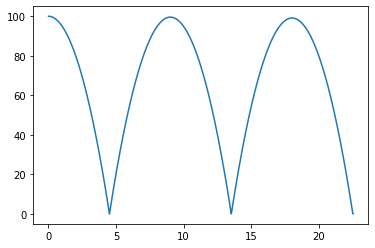

In [245]:
loc_history = np.empty((2,0))


ball = SimulationObject(acc=(0,gravity), vel=(1,0), loc=(0,100), bounce_cor=1)
floor = Obstacle((0,0), (100,0))

while(ball.collision_counter < collisions):
        ball.update(dt, obstacle=floor)
        loc_history = np.concatenate((loc_history, np.vstack(ball.loc)), axis=1) # ToDo understand concatenate axis better

td_acc_history = np.arange(0, len(loc_history[1]))*dt

#plt.plot(td_acc_history, loc_history[1])
plt.plot(loc_history[0], loc_history[1])


In [246]:
#ToDo
# multiple boundaries
# funnel
# animate

In [247]:
"""
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

scat = ax.plot3D(loc_history[0], loc_history[1] ,loc_history[2])

# Create cubic bounding box to simulate equal aspect ratio, since matplotlib3d does not support aspect=equal
max_range = np.array([loc_history[0].max()-loc_history[0].min(), loc_history[1].max()-loc_history[1].min(), loc_history[2].max()-loc_history[2].min()]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(loc_history[0].max()+loc_history[0].min())
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(loc_history[1].max()+loc_history[1].min())
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(loc_history[2].max()+loc_history[2].min())

for xb, yb, zb in zip(Xb, Yb, Zb):
   ax.plot([xb], [yb], [zb], 'w')

plt.grid()
plt.show()
"""

"\nfig = plt.figure()\nax = fig.add_subplot(projection='3d')\n\nscat = ax.plot3D(loc_history[0], loc_history[1] ,loc_history[2])\n\n# Create cubic bounding box to simulate equal aspect ratio, since matplotlib3d does not support aspect=equal\nmax_range = np.array([loc_history[0].max()-loc_history[0].min(), loc_history[1].max()-loc_history[1].min(), loc_history[2].max()-loc_history[2].min()]).max()\nXb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(loc_history[0].max()+loc_history[0].min())\nYb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(loc_history[1].max()+loc_history[1].min())\nZb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(loc_history[2].max()+loc_history[2].min())\n\nfor xb, yb, zb in zip(Xb, Yb, Zb):\n   ax.plot([xb], [yb], [zb], 'w')\n\nplt.grid()\nplt.show()\n"